In [8]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%reload_ext autoreload

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [34]:
from skimage.filters import threshold_otsu
from scipy.signal import savgol_filter

def extract_extrema(arr):    
    idxs = np.arange(arr.shape[0])
    min_idxs = []
    max_idxs = []
    for i in range(1, arr.shape[0] - 1):
        if arr[i - 1] < arr[i] > arr[i + 1]:
            max_idxs.append(i)
        elif arr[i - 1] > arr[i] < arr[i + 1]:
            min_idxs.append(i)
    return min_idxs, max_idxs
    
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smooth_trace(trace, wnd=9, poly=2):
    return savgol_filter(trace, wnd, poly)  # window size 5, polynomial order 2

def find_extrema_and_peaks(data, thr=.1):
    extrema_idxs = []
    extrema_diffs = []

    for trace in data:
        # Identify extrema
        mins, maxs = extract_extrema(trace)

        # Combine, sort, and add indexes for first and last timepoints (needed to compute all needed differentials)
        extrema = np.sort(np.concatenate((np.array(mins), np.array(maxs))))
        extrema = np.insert(extrema, 0, 0)
        extrema = np.append(extrema, trace.shape[-1]-1)

        # Normalize trace to [0,1] range and compute average diff (before and after) for each extrema
        trace_norm = (trace-trace.min())/(trace.max()-trace.min())
        extrema_y = [trace_norm[i] for i in extrema]
        extrema_diff = np.abs(np.diff(extrema_y))
        avg_extrema_diff = moving_average(extrema_diff)

        # Append values
        extrema_idxs.append(extrema)
        extrema_diffs.append(avg_extrema_diff)

    # Find Otsu threshold for extrema inclusion
    # thr = threshold_otsu(np.concatenate(extrema_diffs))

    # Identify real extrema
    real_extrema = [bout > thr for bout in extrema_diffs]

    # Recapitulate positions and amplitudes for all extrema
    real_extrema_idxs = [extrema_idxs[bout][1:-1][real_extrema[bout]] for bout in range(len(real_extrema))]
    real_extrema_diff = [[np.diff(data[bout])[i] for i in real_extrema_idxs[bout]] for bout in range(len(real_extrema))]

    peaks_i = [real_extrema_idxs[bout][np.array(real_extrema_diff[bout]) < 0] for bout in range(len(real_extrema))]
    peaks_a = [[data[bout, i] for i in peaks_i[bout]] for bout in range(len(real_extrema))]

    valleys_i = [real_extrema_idxs[bout][np.array(real_extrema_diff[bout]) > 0] for bout in range(len(real_extrema))]
    valleys_a = [[data[bout, i] for i in valleys_i[bout]] for bout in range(len(real_extrema))]
    
    return peaks_a, peaks_i, valleys_a, valleys_i


def extract_peaks_valleys_arrays(data, peaks_a, peaks_i, valleys_a, valleys_i, max_n=9):
    """
    Function to extract and fill arrays for peaks and valleys.

    Parameters:
    - data: numpy.ndarray, the original data array from which peaks and valleys are derived.
    - peaks_a: list of lists, amplitudes of peaks for each trace.
    - peaks_i: list of lists, indices of peaks for each trace.
    - valleys_a: list of lists, amplitudes of valleys for each trace.
    - valleys_i: list of lists, indices of valleys for each trace.
    - max_n: int, maximum number of peaks/valleys to store for each trace (default is 9).

    Returns:
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: numpy.ndarrays filled with peak/valley data.
    """
    num_traces = data.shape[0]
    
    # Initialize arrays with NaN
    peaks_a_array = np.full((num_traces, max_n), np.nan)
    peaks_i_array = np.full((num_traces, max_n), np.nan)
    valleys_a_array = np.full((num_traces, max_n), np.nan)
    valleys_i_array = np.full((num_traces, max_n), np.nan)

    # Fill arrays with peak and valley data
    for i in range(num_traces):
        peak_count = min(len(peaks_a[i]), max_n)
        valley_count = min(len(valleys_a[i]), max_n)
        
        peaks_a_array[i, :peak_count] = peaks_a[i][:peak_count]
        peaks_i_array[i, :peak_count] = peaks_i[i][:peak_count]
        valleys_a_array[i, :valley_count] = valleys_a[i][:valley_count]
        valleys_i_array[i, :valley_count] = valleys_i[i][:valley_count]
    
    return peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array


In [35]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array

In [36]:
sns.set_theme(style="white", palette="pastel")

## Load data

In [37]:
# master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

# fish_paths = list(master_path.glob('*f[0-9]*'))
# fish_paths

In [38]:
## Analysed for paper

# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\230307_visstim_2D") #rectangular arena # start from fish 1
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_round")
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_2") #rectangular arena
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\13052024_visstim_2D_round")
master_path = Path(r"\\portulab.synology.me\data\Kata\Data\14052024_visstim_2D_round")

In [39]:
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)

([WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f1'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f2'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f3'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f4'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f5'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f6'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f7'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f8'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f9')],
 10)

In [40]:
fish= 0
fish_id =  fish_paths[fish].name
exp_name = Path(fish_paths[fish]).parts[-2]
# exp_name = 'testfish'
fish_id, exp_name


('240514_f0', '14052024_visstim_2D_round')

In [41]:
# out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

In [42]:
## Analysed for paper

# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\230307_visstim_2D_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_round_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_2_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\13052024_visstim_2D_round_")
out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\14052024_visstim_2D_round_")

In [43]:
save_data_path = out_path

## Load traces and make tensor in shape (trials, tails, left fin, right fin)

In [44]:
bout_data = fl.load(out_path/'{}_bout_data.h5'.format(fish_id))
bout_data.keys()

dict_keys(['body_angles', 'body_angles_delta', 'bout_times', 'cluster', 'dlc_filter', 'edge_filter', 'eye_angles', 'eye_rotation', 'eye_vergence', 'fin_angles', 'mb_proba', 'motor', 'tail_vectors', 'tailsums'])

In [63]:
data = fl.load(out_path / '{}_tensor.h5'.format(fish_id))
indices = fl.load(out_path / '{}_indices.h5'.format(fish_id))
data.shape


(192, 3, 50)

In [64]:
## specify 0 for tail, 1 for l fin and 2 for right fin
## because we dont want to confuse peaks and vallyes later -> left invert l fin

data_tail = data[:,0,:]
data_l_fin = data[:,1,:]*-1
data_r_fin = data[:,2,:]


In [46]:
### flip tail to all be on the same side?

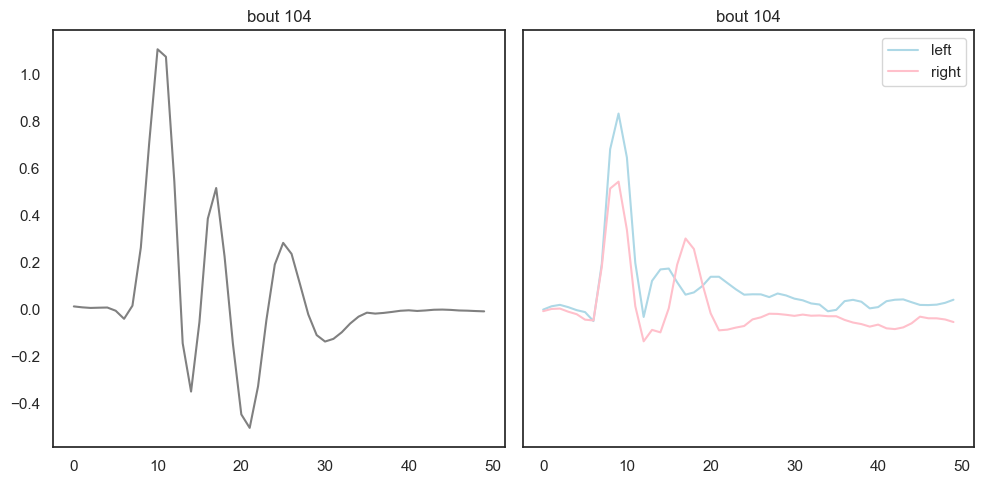

In [67]:
bout = np.random.randint(0,data_tail.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(data_tail[bout,:], c='gray', label='tail')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(data_l_fin[bout,:], c='lightblue', label='left')
axes[1].plot(data_r_fin[bout,:], c='pink', label='right')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()

# Code to extract peaks and valleys

In [81]:
datas = [data_tail, data_l_fin, data_r_fin]
feat_array_lists = []

for data_ in datas:
    # data = np.apply_along_axis(smooth_trace, 1, data_)
    peaks_a, peaks_i, valleys_a, valleys_i = find_extrema_and_peaks(data_, thr=.2)

    peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array = extract_peaks_valleys_arrays(data_, peaks_a, peaks_i, valleys_a, valleys_i, max_n=9)
    # concatenate feature array
    feature_vector_array = np.concatenate([peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array], axis=1)
    feat_array_lists.append(feature_vector_array)
    
fl.save(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id), feat_array_lists[0])
fl.save(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id), feat_array_lists[1])
fl.save(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id), feat_array_lists[2])

In [82]:
feat_array_lists[0].shape

(192, 36)

In [83]:
feat_array_lists[0].shape

(192, 36)

In [84]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(feat_array_lists[0])
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(feat_array_lists[1])
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(feat_array_lists[2])

Reshaped array shape: (192, 4, 9)
Reshaped array shape: (192, 4, 9)
Reshaped array shape: (192, 4, 9)


## Plot random ROI to check

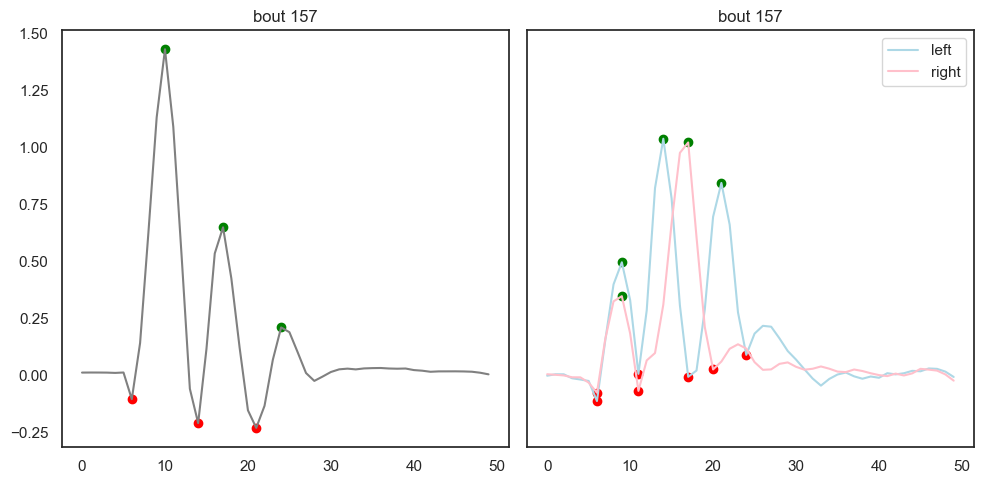

In [95]:
bout = np.random.randint(0,data_tail.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(data_tail[bout,:], c='gray', label='tail')
axes[0].scatter(t_peaks_i_array[bout], t_peaks_a_array[bout], c='green')
axes[0].scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(data_l_fin[bout,:], c='lightblue', label='left')
axes[1].scatter(l_peaks_i_array[bout], l_peaks_a_array[bout], c='green')
axes[1].scatter(l_valleys_i_array[bout], l_valleys_a_array[bout], c='red')

axes[1].plot(data_r_fin[bout,:], c='pink', label='right')
axes[1].scatter(r_peaks_i_array[bout],r_peaks_a_array[bout], c='green')
axes[1].scatter(r_valleys_i_array[bout], r_valleys_a_array[bout], c='red')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()